In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.0MB/s]


In [3]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C,H, W] : {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C,H, W] : torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
import matplotlib.pyplot as plt

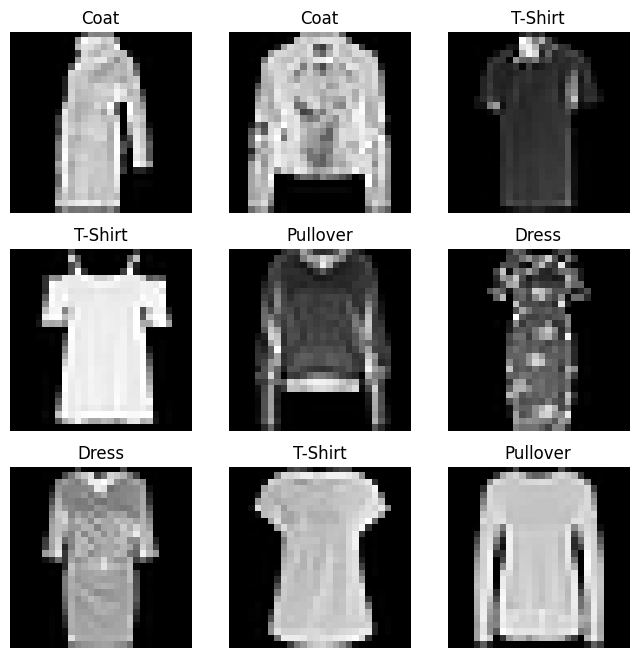

In [6]:
labels_map={
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1, )).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch+1) * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()

  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error :\n Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f}")

In [13]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n---------------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
---------------------------------------
loss: 2.295558 [   64/60000]
loss: 2.287379 [ 6464/60000]
loss: 2.268744 [12864/60000]
loss: 2.271376 [19264/60000]
loss: 2.235438 [25664/60000]
loss: 2.216011 [32064/60000]
loss: 2.227984 [38464/60000]
loss: 2.192384 [44864/60000]
loss: 2.182962 [51264/60000]
loss: 2.153159 [57664/60000]
Test Error :
 Accuracy:37.5%, Avg loss:2.152705
Epoch 2
---------------------------------------
loss: 2.157468 [   64/60000]
loss: 2.150382 [ 6464/60000]
loss: 2.095336 [12864/60000]
loss: 2.114981 [19264/60000]
loss: 2.050828 [25664/60000]
loss: 2.001839 [32064/60000]
loss: 2.023647 [38464/60000]
loss: 1.948004 [44864/60000]
loss: 1.939079 [51264/60000]
loss: 1.872172 [57664/60000]
Test Error :
 Accuracy:55.2%, Avg loss:1.877436
Epoch 3
---------------------------------------
loss: 1.901211 [   64/60000]
loss: 1.876019 [ 6464/60000]
loss: 1.765241 [12864/60000]
loss: 1.804991 [19264/60000]
loss: 1.683891 [25664/60000]
loss: 1.646909 [32064/60000]
loss: 

In [15]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [16]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [17]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [20]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
